# Analysis of sECG and respiratory signal (Figure 2a/b)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas
from scipy import optimize

from neuromorphicOscillatorsForPacemakers.ECG.ECGRecoding import ECGRecording
from neuromorphicOscillatorsForPacemakers.utils.utils_tuning.CurveFitter import CurveFitter

def get_r2_for_fit(arguments):
    b=arguments[0]
    c=arguments[1]
    d=arguments[2]
    e=arguments[3]
    ECG_trace.set_breathing_coefficient_trace(b=b, c=c, d=d, e=e)
    breathing_coeffs, r_peak_delays = ECG_trace.get_dataset_breathing_coeff_vs_r_peak_delays(rpeaks_indices=ECG_trace.rpeaks_indices,
                                                                                             breathing_coefficient_trace=ECG_trace.breathing_coefficient_trace,
                                                                                             dt=1./ECG_trace.sampling_rate)
    z = np.polyfit(breathing_coeffs, r_peak_delays, deg=2)
    p = np.poly1d(z)
    r2 = CurveFitter().get_r_square_of_fit(r_peak_delays, p(breathing_coeffs))
    return 1-r2

## look at sECG and respiratory signal recording of dog at rest

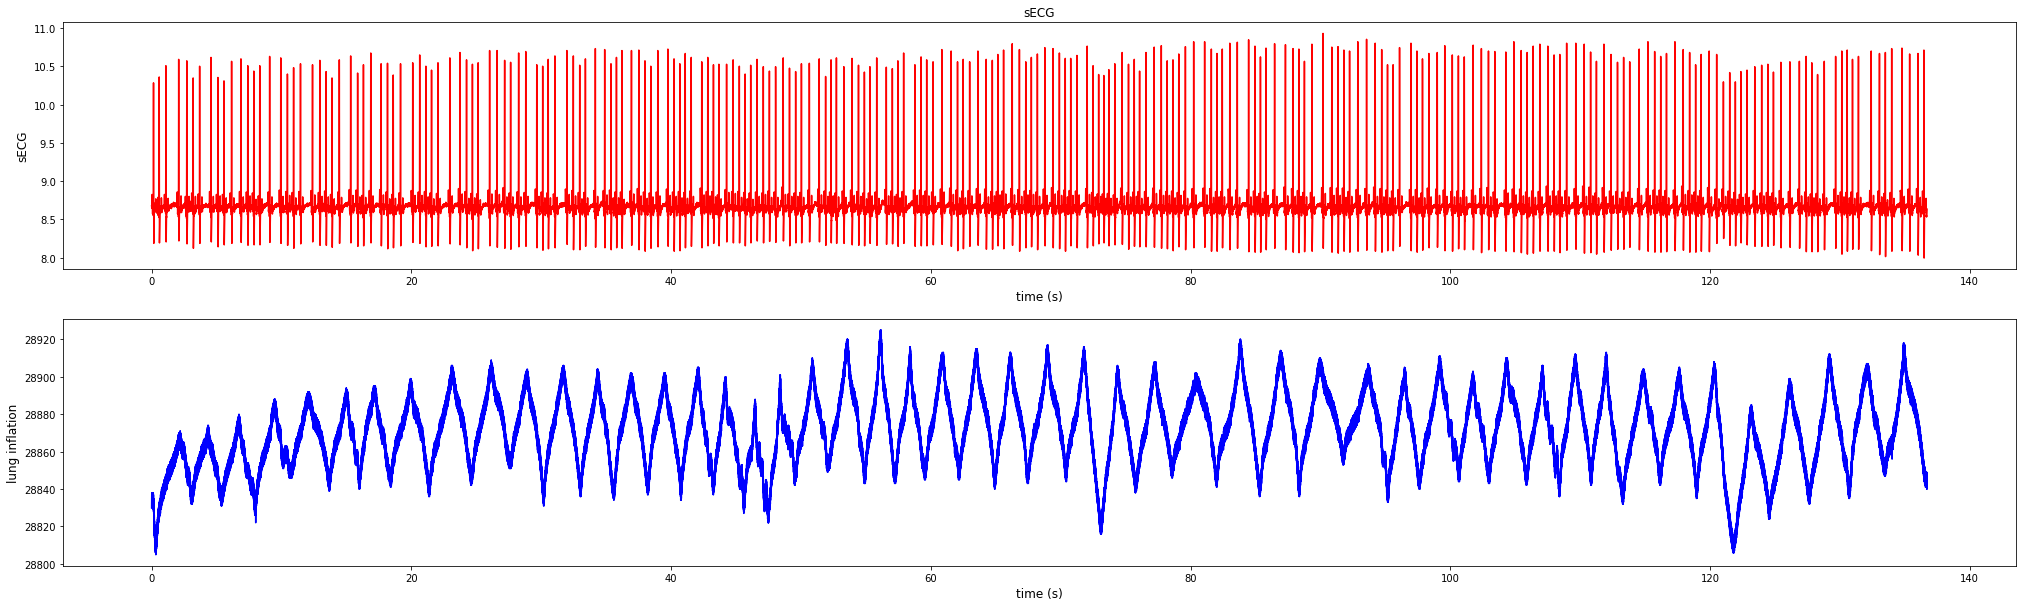

In [2]:
inputfilename = 'ECG/recording_sECG_and_respiratorySignal.xlsx'
ecg_df = pandas.read_excel(inputfilename)
ECG_trace = ECGRecording(dog_nr=167607, gender='male', path_to_rec=inputfilename, exp_date='20190710', duration=1000.,
                         t_rec=np.asarray(ecg_df['Time (sec)']), sampling_rate=256., lung_inflation=np.asarray(ecg_df['Respiration']),
                         activity=np.asarray(ecg_df['Activity']), sECG_trace=np.asarray(ecg_df['ECG (mV)']))
# restrict recording to "at rest" only
ECG_trace.restrict_ECGRecording_to_range(idx_start=0, idx_end=35000, names_traces=['sECG_trace', 'lung_inflation', 'activity', 't_rec'])
fig, (ax1, ax2) = plt.subplots(figsize=(35, 10), nrows=2)
ECG_trace.plot_trace(trace_name='sECG_trace', title='sECG', xlabel='time (s)', ylabel='sECG', subfig=ax1, color='r')
ECG_trace.plot_trace(trace_name='lung_inflation', title='', xlabel='time (s)', ylabel='lung inflation', subfig=ax2, color='b')

## extract r-peaks and peaks in lung inflation

/home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/renate/SciSoftZeagull/anaconda/envs/conda_ctxctr_37/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensio

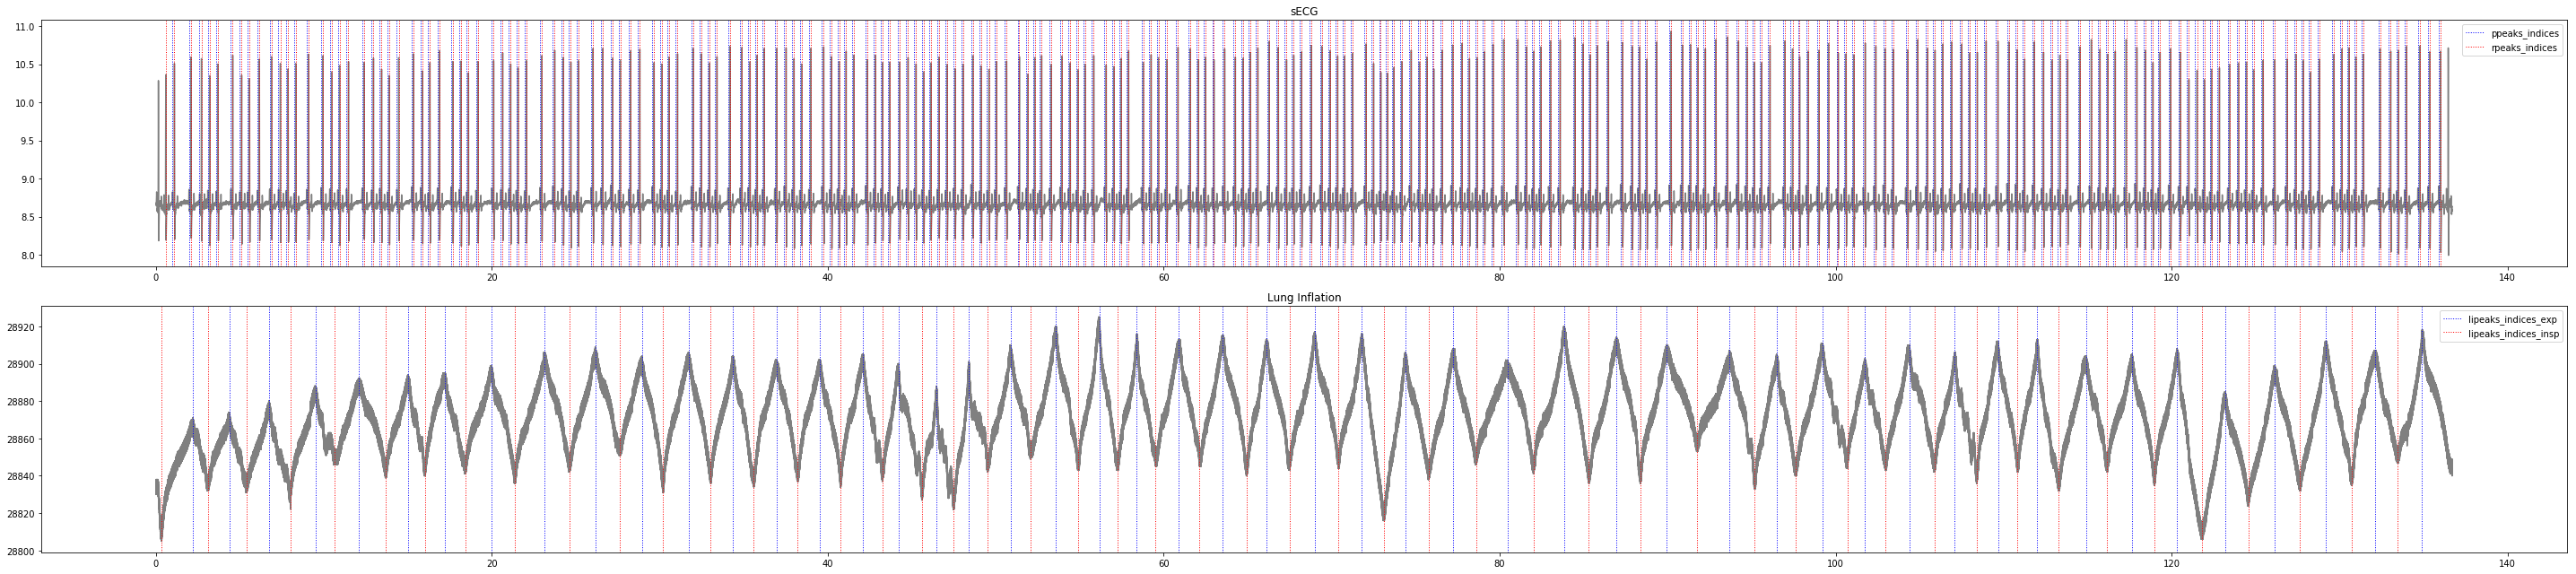

In [3]:
ECG_trace.extract_p_and_r_peaks()
ECG_trace.extract_lunginflation_peaks(peak_dist=100., peak_width=50.)

# plot
t_start = 0
t_end = None
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(40, 9))
ECG_trace.plot_trace('sECG_trace', title='sECG', t_start=t_start, t_end=t_end, subfig=ax1, color='grey')
ECG_trace.plot_extracted_peaks('ppeaks_indices', t_start=t_start, t_end=t_end, subfig=ax1, color='b')
ECG_trace.plot_extracted_peaks('rpeaks_indices', t_start=t_start, t_end=t_end, subfig=ax1, color='r')
ax1.legend()

ECG_trace.plot_trace('lung_inflation', title='Lung Inflation', t_start=t_start, t_end=t_end, subfig=ax2, color='grey')
ECG_trace.plot_extracted_peaks('lipeaks_indices_exp', t_start=t_start, t_end=t_end, subfig=ax2, color='b')
ECG_trace.plot_extracted_peaks('lipeaks_indices_insp', t_start=t_start, t_end=t_end, subfig=ax2, color='r')
ax2.legend()
plt.tight_layout()

## define respiration phase and optimize parameters to fit breathing coefficient

In [4]:
ECG_trace.set_expiration_phase_trace()
ECG_trace.set_inspiration_phase_trace()

# breathing coefficient - initial default values
init_b = 2    # b: slope around the inflection point (can be positive or negative and, consequently, Y may increase or decrease as X increases)
init_c = 0    # c: lower asymptote
init_d = 900  # d: higher asymptote
init_e = .5   # e: X value producing a response half-way between d and c
result = optimize.minimize(get_r2_for_fit, x0=[init_b, init_c, init_d, init_e], method='CG')
print(result)

     fun: 0.363376505001052
     jac: array([-3.12924385e-07,  0.00000000e+00, -1.49011612e-08,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 11
    njev: 25
  status: 0
 success: True
       x: array([3.02224874e+00, 4.94697663e-08, 9.00000000e+02, 4.74684468e-01])


## Figure 2a

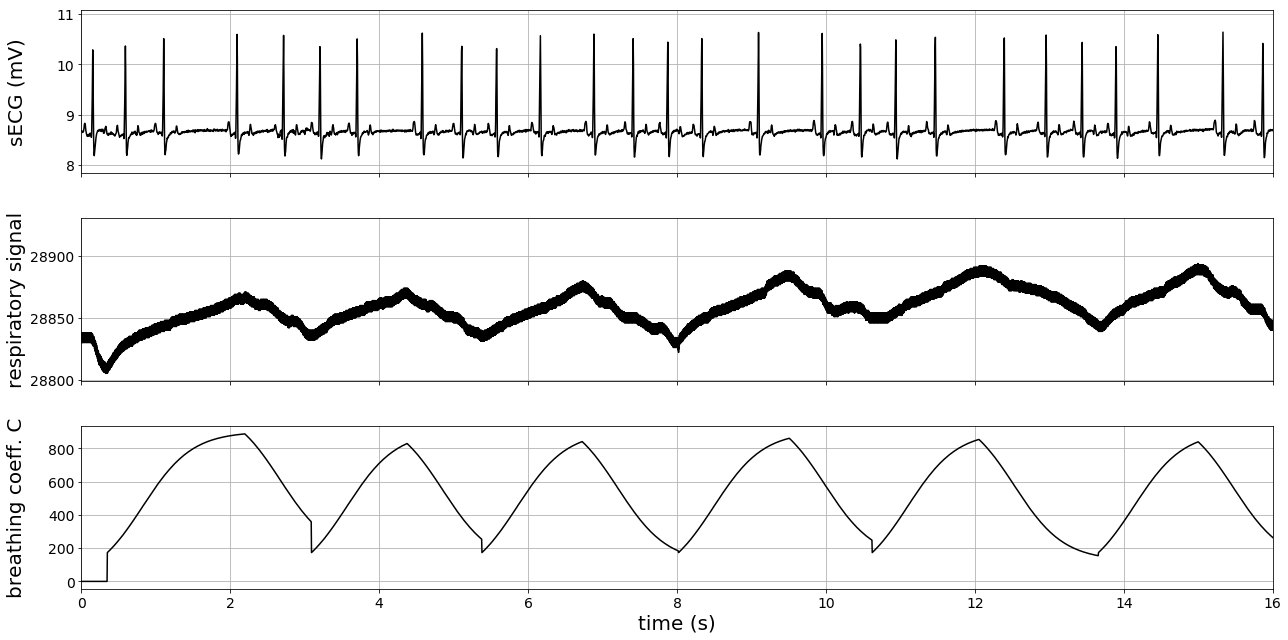

In [5]:
fontsize=24-4
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 9), nrows=3)
ECG_trace.plot_trace(trace_name='sECG_trace', t_start=0, t_end=5000, title='', xlabel='', ylabel='sECG (mV)', subfig=ax1, color='k', fontsize=fontsize)
ECG_trace.plot_trace(trace_name='lung_inflation', t_start=0, t_end=5000, title='', xlabel='', ylabel='respiratory signal', subfig=ax2, color='k', fontsize=fontsize)
ECG_trace.plot_trace(trace_name='breathing_coefficient_trace', t_start=0, t_end=5000, title='', xlabel='time (s)', ylabel='breathing coeff. C', subfig=ax3, color='k', fontsize=fontsize)

fig.align_ylabels([ax1, ax2, ax3])
for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.set_xlim([0, 16])
    ax.xaxis.set_tick_params(labelsize=fontsize-6)
    ax.yaxis.set_tick_params(labelsize=fontsize-6)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
plt.tight_layout()

## Figure 2b

b,c,d,e =  [3.02224874e+00 4.94697663e-08 9.00000000e+02 4.74684468e-01]

 G(c) =            2
7.02e-07 x - 0.0001827 x + 0.4498 
 parameters: [ 7.01970271e-07 -1.82705418e-04  4.49817096e-01]
goodness of fit (R2): 0.636623494998948


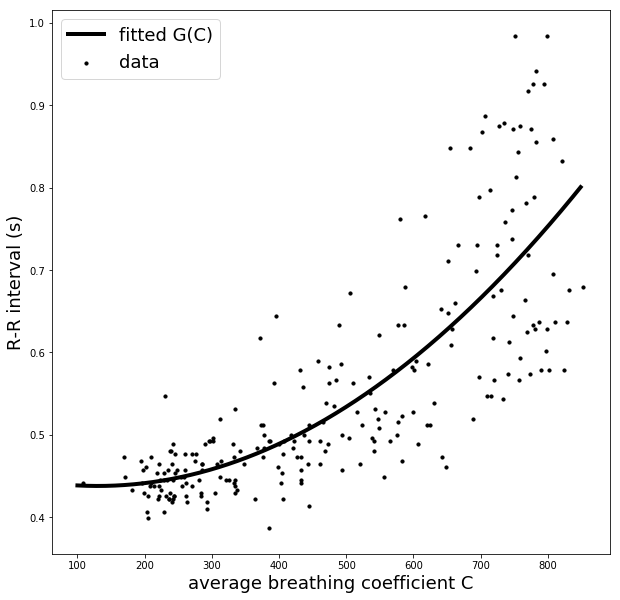

In [6]:
ECG_trace.set_breathing_coefficient_trace(b=result.x[0], c=result.x[1], d=result.x[2], e=result.x[3])
breathing_coeffs, r_peak_delays = ECG_trace.get_dataset_breathing_coeff_vs_r_peak_delays(rpeaks_indices=ECG_trace.rpeaks_indices,
                                                                                             breathing_coefficient_trace=ECG_trace.breathing_coefficient_trace,
dt=1./ECG_trace.sampling_rate)
xdata = breathing_coeffs
ydata = r_peak_delays
fitted_parameters = np.polyfit(xdata, ydata, deg=2)
fitted_function   = np.poly1d(fitted_parameters)

fig = plt.figure(figsize=(10, 10))
plt.plot(np.arange(100, 850, 1), fitted_function(np.arange(100, 850, 1)), 'k', label='fitted G(C)', linewidth=4)
plt.scatter(xdata, ydata, s=10, color='k', label='data')
plt.xlabel('average breathing coefficient C', fontsize=18)
plt.ylabel('R-R interval (s)', fontsize=18)
plt.legend(fontsize=18)

print('b,c,d,e = ', result.x)
print('\n G(c) = ', fitted_function, '\n parameters:', fitted_parameters)
print('goodness of fit (R2):', CurveFitter().get_r_square_of_fit(ydata, fitted_function(xdata)))